In [85]:
import os
import numpy.random as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly_express as px

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#displaying numbers instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#for creating wordcloud
from wordcloud import WordCloud, STOPWORDS

In [22]:
#import the surveys
df = pd.read_csv('visit_survey.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 8 columns):
Unnamed: 0        67 non-null object
Unnamed: 1        661 non-null object
Unnamed: 2        143 non-null object
Unnamed: 3        85 non-null object
Unnamed: 4        120 non-null object
Survey Results    61 non-null object
Unnamed: 6        31 non-null object
Unnamed: 7        31 non-null object
dtypes: object(8)
memory usage: 61.2+ KB


## Clean Reviews for Text Analysis

In [45]:
#take reviews out of csv
reviews = pd.DataFrame(df.iloc[:, 1]).dropna().rename(columns = {'Unnamed: 1':'reviews'}).reset_index(drop = True)
reviews.head(20)

,reviews
0,Time Period:
1,Location(s):
2,Provider(s):
3,Appt Type(s):
4,"Survey Results: 1947 Responses, 24197 Sent, 8% Response Rate (1947/24197)"
5,Time Period:
6,Location(s):
7,Provider(s):
8,Appt Type(s):
9,"Survey Results: 1947 Responses, 24197 Sent, 8% Response Rate (1947/24197)"


In [46]:
#cut out first few rows that don't hold any info
reviews = reviews.iloc[15:, :].reset_index(drop = True)
reviews.head(20)

,reviews
0,"Please let us know if you would like to recognize outstanding service from an employee or if there is anything we could have done better. If you would like to be contacted, please leave your name and phone number."
1,
2,07/03/2018 - Front desk and check out staff are not nearly as nice as the professionals in the back. Check out lady acts like she doesn?t want to wait on you.
3,07/03/2018 - Complete attention & care. More than expected!!
4,"07/03/2018 - My doctor, Dr. Walcott was very professional and kind. All the employees that took care of me were very professional and efficient"
5,07/03/2018 - All is great
6,"07/03/2018 - Dr Venarsky is outstanding, as well as the staff. I had an insurance question, and Nicki was so helpful. You guys are greatly appreciated."
7,07/03/2018 - We love y?all!!
8,07/04/2018 - Dr veristty was excellent. Made my daughter feel comfortable and at ease. Also was great at communicating to her on the issues. Highly recommend him
9,07/05/2018 - Nurse kelly. Dr Walcott i love this clinic.


In [47]:
#extract dates from text and make them the index
# (?P<Date>....) - named capturing group
# \d+ 1 or more digits
# (?:\/\d+){2} - non-capturing group repeating twice, where
# \/ - escaped forward slash
# {2} - repeater (two times)
reviews.index = reviews.reviews.str.extract(r'(?P<Date>\d+(?:\/\d+){2})', expand=False).apply(pd.to_datetime)

In [48]:
reviews.head()

,reviews
Date,
NaT,"Please let us know if you would like to recognize outstanding service from an employee or if there is anything we could have done better. If you would like to be contacted, please leave your name and phone number."
NaT,
2018-07-03,07/03/2018 - Front desk and check out staff are not nearly as nice as the professionals in the back. Check out lady acts like she doesn?t want to wait on you.
2018-07-03,07/03/2018 - Complete attention & care. More than expected!!
2018-07-03,"07/03/2018 - My doctor, Dr. Walcott was very professional and kind. All the employees that took care of me were very professional and efficient"


In [63]:
#remove dates and symbols from reviews with regex, strip all white space
reviews['reviews'].replace(regex=True,inplace = True, to_replace=r'\d|\W',value=r' ')

In [67]:
#strip all whitespace to the left of the text, created through removing dates from reviews
reviews['reviews'] = reviews.reviews.str.lstrip()

In [68]:
reviews.head()

,reviews
Date,
NaT,Please let us know if you would like to recognize outstanding service from an employee or if there is anything we could have done better If you would like to be contacted please leave your name and phone number
NaT,
2018-07-03,Front desk and check out staff are not nearly as nice as the professionals in the back Check out lady acts like she doesn t want to wait on you
2018-07-03,Complete attention care More than expected
2018-07-03,My doctor Dr Walcott was very professional and kind All the employees that took care of me were very professional and efficient


## Generating A Wordcloud From Reviews
- __Here I am going to create an overall wordcloud to see what the most common words are from the reviews__
- __While this will show the common words, it will not reflect the negative reviews most likely since those are mentioned less, so I want to parse those out eventually using sentiment analysis__
- __I should probably also look into removing specific words, like "Dr." so that the wordcloud doesn't have to waste space with these, it is essentially a stop word here__

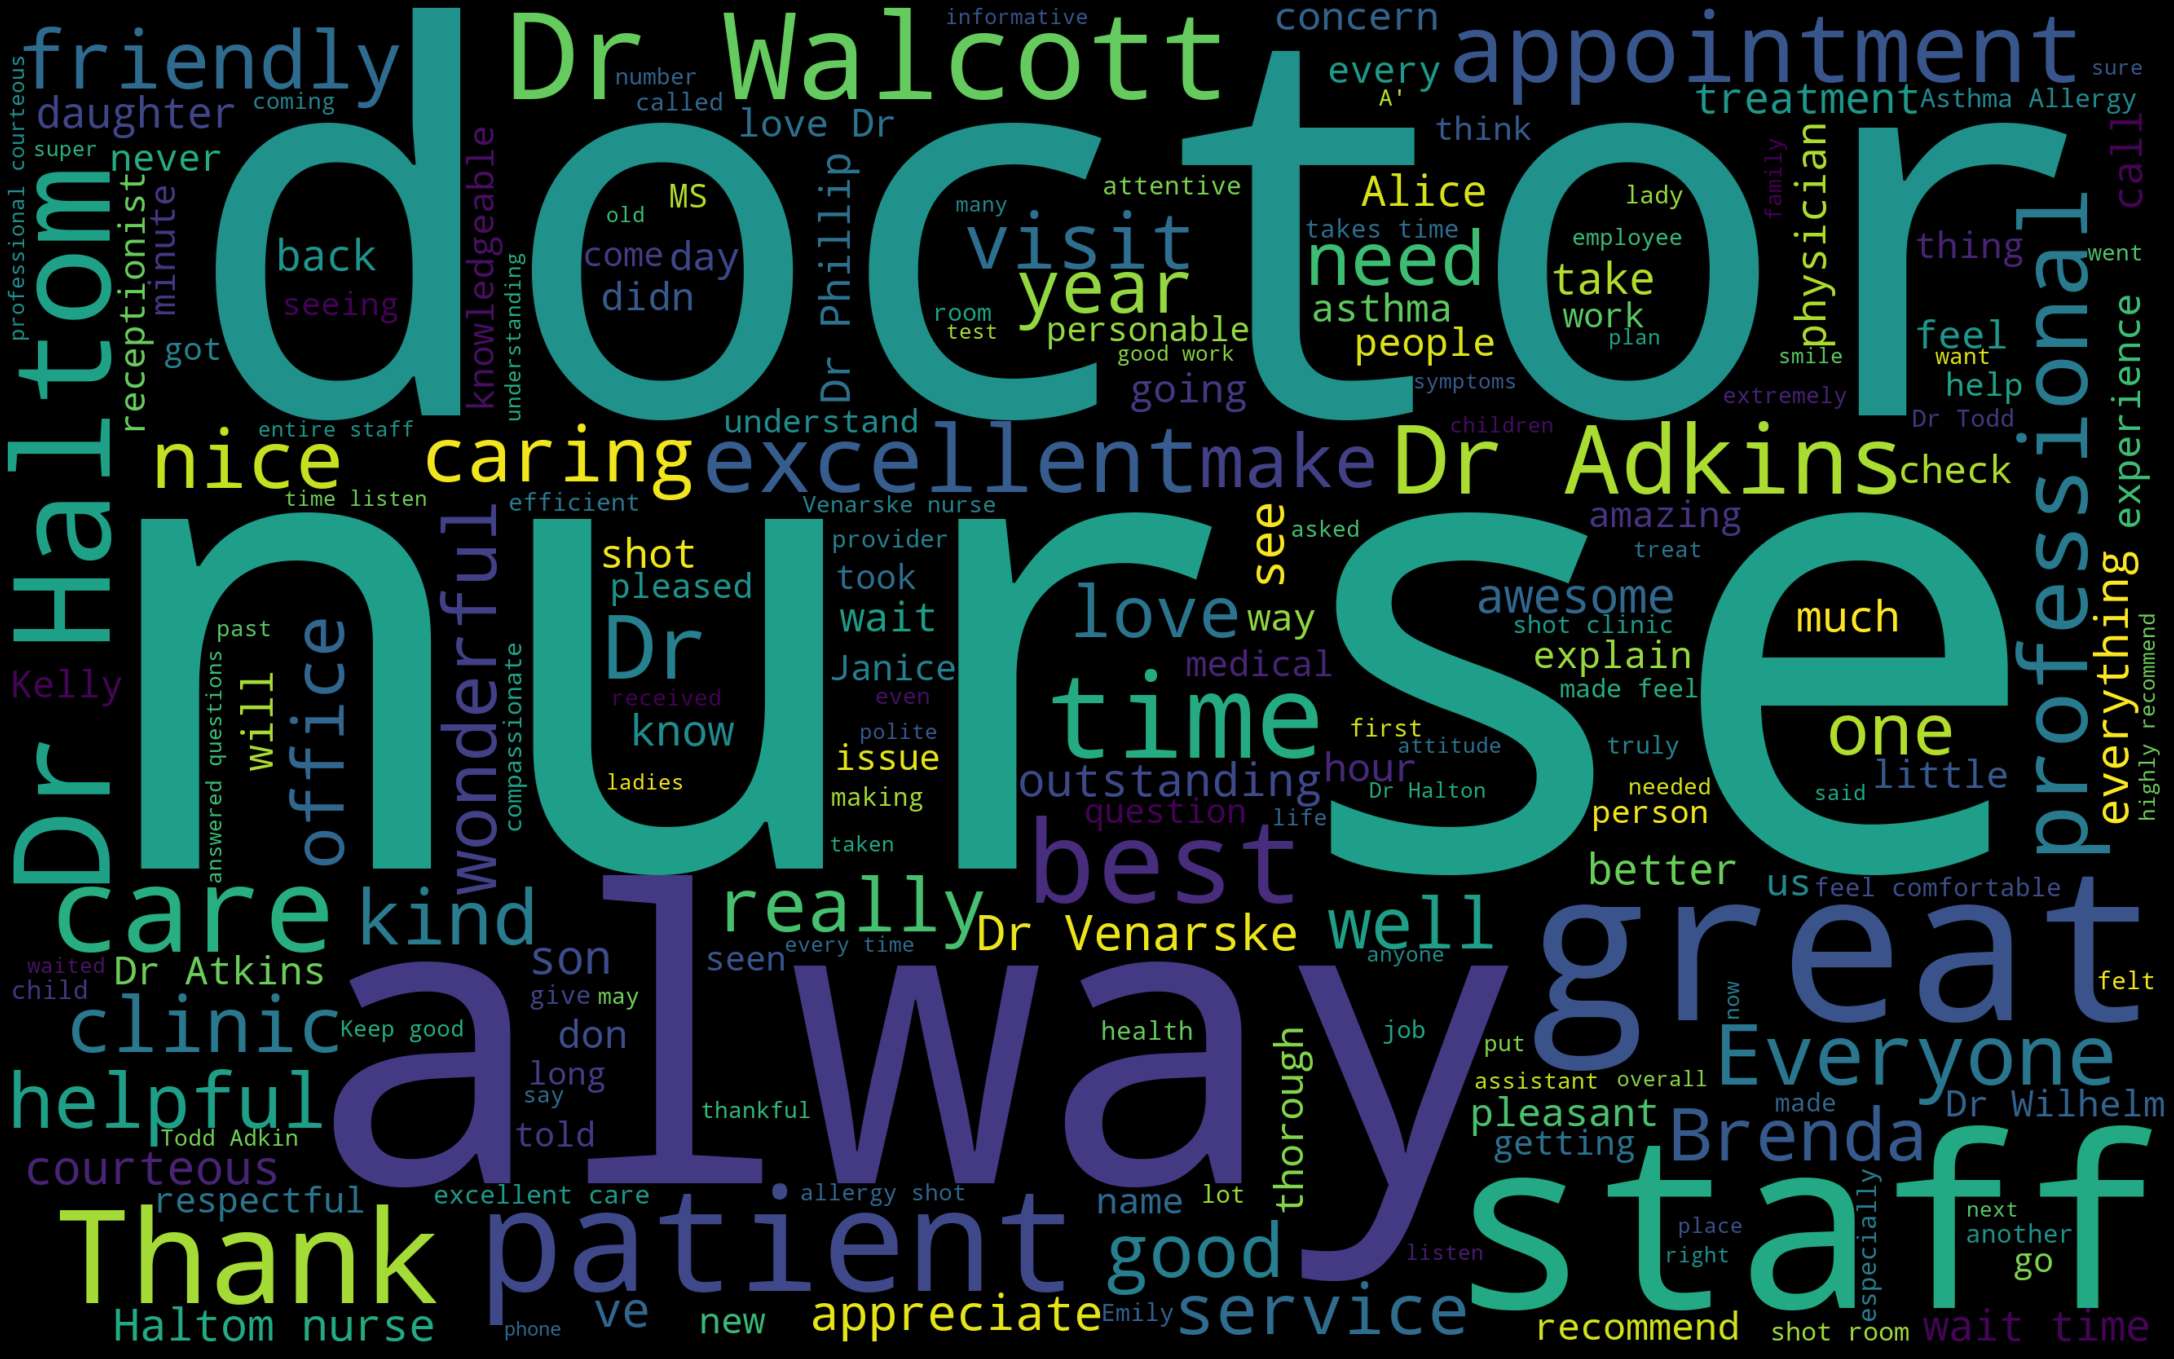

In [90]:
text = reviews.reviews.values
wordcloud = WordCloud(
    width = 2650,
    height = 1650,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

In [96]:
reviews.head()

,reviews
Date,
NaT,Please let us know if you would like to recognize outstanding service from an employee or if there is anything we could have done better If you would like to be contacted please leave your name and phone number
NaT,
2018-07-03,Front desk and check out staff are not nearly as nice as the professionals in the back Check out lady acts like she doesn t want to wait on you
2018-07-03,Complete attention care More than expected
2018-07-03,My doctor Dr Walcott was very professional and kind All the employees that took care of me were very professional and efficient
